# E-commerce Return Rate Reduction Analysis - Clean, EDA & Predictive Modeling

#### Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

#### Step 1: Data Extraction

In [2]:
# Load Data

In [6]:
df = pd.read_csv("Customer360Insights.csv")

In [7]:
# Display basic info to assess columns and data quality

In [8]:
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   SessionStart           2000 non-null   object
 1   CustomerID             2000 non-null   int64 
 2   FullName               2000 non-null   object
 3   Gender                 2000 non-null   object
 4   Age                    2000 non-null   int64 
 5   CreditScore            2000 non-null   int64 
 6   MonthlyIncome          2000 non-null   int64 
 7   Country                2000 non-null   object
 8   State                  2000 non-null   object
 9   City                   2000 non-null   object
 10  Category               2000 non-null   object
 11  Product                2000 non-null   object
 12  Cost                   2000 non-null   int64 
 13  Price                  2000 non-null   int64 
 14  Quantity               2000 non-null   int64 
 15  CampaignSchema       

(None,
           SessionStart  CustomerID           FullName  Gender  Age  \
 0  2019-01-01 02:42:00        1001  Brittany Franklin    Male   57   
 1  2019-01-02 20:35:00        1002      Scott Stewart  Female   69   
 2  2019-01-04 03:11:00        1003   Elizabeth Fowler  Female   21   
 3  2019-01-05 09:01:00        1004        Julian Wall  Female   67   
 4  2019-01-05 13:35:00        1005      James Simmons    Male   57   
 
    CreditScore  MonthlyIncome Country      State        City  ... Price  \
 0          780           7591   China  Guangdong    Dongguan  ...    50   
 1          746           3912   China   Shandong      Yantai  ...    80   
 2          772           7460      UK    England  Birmingham  ...    20   
 3          631           4765      UK    England  Birmingham  ...    20   
 4          630           3268   China   Shandong      Yantai  ...   100   
 
   Quantity    CampaignSchema      CartAdditionTime  OrderConfirmation  \
 0        4      Instagram-ads  2

In [9]:
# Clean column names to avoid KeyError due to spaces or special characters

In [10]:
df.columns = df.columns.str.strip().str.replace(' ', '').str.replace('(', '').str.replace(')', '')

In [11]:
# Print columns

In [12]:
print(df.columns.tolist())

['SessionStart', 'CustomerID', 'FullName', 'Gender', 'Age', 'CreditScore', 'MonthlyIncome', 'Country', 'State', 'City', 'Category', 'Product', 'Cost', 'Price', 'Quantity', 'CampaignSchema', 'CartAdditionTime', 'OrderConfirmation', 'OrderConfirmationTime', 'PaymentMethod', 'SessionEnd', 'OrderReturn', 'ReturnReason']


In [13]:
df['CampaignSchema'].unique()

array(['Instagram-ads', 'Google-ads', 'Facebook-ads', 'Twitter-ads',
       'Billboard-QR code', 'E-mails'], dtype=object)

#### Step 2: Data Filtering

In [14]:
# Remove Duplicates

In [15]:
df = df.drop_duplicates()

In [16]:
# Handle missing values
# Fill missing 'OrderReturn' with 'False' for unconfirmed orders

In [17]:
df['OrderReturn'] = df['OrderReturn'].fillna('False')

In [18]:
# Drop rows where PaymentMethod or OrderConfirmationTime is missing (unconfirmed orders)

In [19]:
df = df.dropna(subset=['OrderConfirmationTime', 'PaymentMethod'])

In [20]:
# Filter only rows with valid Category and Supplier(Product)

In [21]:
df = df[df['Category'].notnull()]
df = df[df['Product'].notnull()]
df = df[df['Country'].notnull()]
df = df[df['CampaignSchema'].notnull()]

#### Step 3: Format dates

In [22]:
date_columns = ['SessionStart', 'CartAdditionTime', 'OrderConfirmationTime', 'SessionEnd']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

#### Step 4: Standardize category fields

In [23]:
df['Category'] = df['Category'].astype(str).str.strip().str.title()
df['Gender'] = df['Gender'].astype(str).str.strip().str.capitalize()
df['CampaignSchema'] = df['CampaignSchema'].astype(str).str.strip().str.title()
df['OrderReturn'] = df['OrderReturn'].astype(str).str.strip().str.capitalize()
df['Product'] = df['Product'].astype(str).str.strip().str.title()

In [24]:
# Replace 'Nan' strings with real NaN

In [25]:
df['CampaignSchema'] = df['CampaignSchema'].replace('Nan', pd.NA)
df['Category'] = df['Category'].replace('Nan', pd.NA)
df['Gender'] = df['Gender'].replace('Nan', pd.NA)
df['Product'] = df['Product'].replace('Nan', pd.NA)

#### Step 5: Aggregation (Return Rate Calculation)

In [26]:
def compute_return_rate(group):
    return np.mean(group['OrderReturn'] == 'True') * 100

In [27]:
# Return rate by Product

In [28]:
return_rate_product = df.groupby('Product').agg(
    ReturnRate_Product=('OrderReturn', lambda x: (x == 'True').mean() * 100)
).reset_index()

In [29]:
# Return rate by Category

In [30]:
return_rate_category = df.groupby('Category').agg(
    ReturnRate_Category=('OrderReturn', lambda x: (x == 'True').mean() * 100)
).reset_index()

In [31]:
# Merge return rates back to original dataframe

In [32]:
df = df.merge(return_rate_product, on='Product', how='left')
df = df.merge(return_rate_category, on='Category', how='left')

#### Step 6: Aggregation in Pandas

In [33]:
# Return Reasons

In [34]:
return_reasons = df[df['OrderReturn'] == 'True']['ReturnReason'].value_counts(normalize=True) * 100
print("\n--- Top Return Reasons (%) ---")
print(return_reasons.head(10))


--- Top Return Reasons (%) ---
ReturnReason
Poor Value         23.305085
Wrong Item         20.762712
Arrived Late       19.915254
Arrived Damaged    19.067797
Poor Quality       16.949153
Name: proportion, dtype: float64


In [35]:
# Return rate by Category

In [36]:
return_rate_by_category = df.groupby('Category').agg(
    OrderCount=('Product', 'count'),
    ReturnRate_Percent=('OrderReturn', lambda x: (x == 'True').mean() * 100)
    ).reset_index().sort_values(by='ReturnRate_Percent', ascending=False)

print("\n--- Return Rate by Category ---")
print(return_rate_by_category.head(10))


--- Return Rate by Category ---
          Category  OrderCount  ReturnRate_Percent
2          Fashion         334           15.269461
0            Books         345           14.492754
4             Toys         360           13.888889
3  Home Appliances         357           13.725490
1      Electronics         304           11.842105


In [37]:
# Return rate by Geography

In [38]:
return_rate_by_geography = df.groupby(['Country', 'State', 'City']).agg(
    TotalOrders=('Product', 'count'),
    ReturnRate_Percent=('OrderReturn', lambda x: np.mean(x == 'True') * 100)
).reset_index().sort_values(by='ReturnRate_Percent', ascending=False)

print("\n--- Return Rate by Geography (Country, State, City) ---")
print(return_rate_by_geography.head(10))


--- Return Rate by Geography (Country, State, City) ---
   Country          State         City  TotalOrders  ReturnRate_Percent
14   China      Guangdong     Shenzhen           26           26.923077
37   Spain      Andalusia       Malaga           36           25.000000
16   China       Shandong      Qingdao           43           23.255814
29   Italy       Lombardy        Milan           31           22.580645
22   India  Uttar Pradesh       Kanpur           41           21.951220
12   China      Guangdong     Dongguan           33           21.212121
11  Canada         Quebec  Quebec City           29           20.689655
25   Italy          Lazio       Latina           30           20.000000
42      UK        England   Birmingham           40           20.000000
13   China      Guangdong    Guangzhou           41           19.512195


In [39]:
# Return rate by Marketing Channel (CampaignSchema)

In [40]:
return_rate_by_channel = df.groupby('CampaignSchema').agg(
    TotalOrders=('Product', 'count'),
    ReturnRate_Percent=('OrderReturn', lambda x: np.mean(x == 'True') * 100)
).reset_index().sort_values(by='ReturnRate_Percent', ascending=False)

print("\n--- Return Rate by Marketing Channel ---")
print(return_rate_by_channel.head(10))


--- Return Rate by Marketing Channel ---
      CampaignSchema  TotalOrders  ReturnRate_Percent
3         Google-Ads          296           16.216216
0  Billboard-Qr Code          278           15.107914
2       Facebook-Ads          288           14.236111
1            E-Mails          273           13.553114
5        Twitter-Ads          265           12.452830
4      Instagram-Ads          300           11.666667


In [41]:
# Return rate by Category & Product

In [42]:
return_rate_by_category_and_product = df.groupby(['Category', 'Product']).agg(
    TotalOrders=('Product', 'count'),
    ReturnRate_Percent=('OrderReturn', lambda x: np.mean(x == 'True') * 100)
).reset_index().sort_values(by='ReturnRate_Percent', ascending=False)

print("\n--- Return Rate by Category and Product ---")
print(return_rate_by_category_and_product.head(10))


--- Return Rate by Category and Product ---
           Category         Product  TotalOrders  ReturnRate_Percent
14  Home Appliances   Mixer Grinder           84           22.619048
18             Toys       Plush Toy           71           19.718310
2             Books           Novel           67           19.402985
10          Fashion           Shoes           96           18.750000
8           Fashion           Dress           77           16.883117
1             Books        Magazine          105           16.190476
16             Toys   Action Figure           97           15.463918
3             Books        Textbook           86           13.953488
12  Home Appliances  Electric Stove           79           13.924051
11          Fashion         T-Shirt           72           13.888889


#### Step 7: Logistic Regression - Predict Probability of Return

In [43]:
# Prepare features

In [44]:
features = ['CustomerID','Category', 'Product', 'CampaignSchema', 'Country', 'Gender']
target = 'OrderReturn'

In [45]:
# Encode categorical variables

In [46]:
df_model = df[features + [target]].dropna()

In [47]:
# Encode all categorical columns

In [48]:
for col in features:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))

In [49]:
# Encode target

In [50]:
df_model[target] = df_model[target].map({'False': 0, 'True': 1})

In [51]:
# Split data

In [52]:
X = df_model[features]
y = df_model[target]

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [54]:
# Train logistic regression

In [55]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [56]:
# Predict

In [57]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

In [58]:
# Evaluate

In [59]:
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, zero_division=0))


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       432
           1       0.00      0.00      0.00        78

    accuracy                           0.85       510
   macro avg       0.42      0.50      0.46       510
weighted avg       0.72      0.85      0.78       510



In [60]:
print("\n--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))


--- Confusion Matrix ---
[[432   0]
 [ 78   0]]


In [61]:
# Probability output

In [62]:
output_prob = X_test.copy()
output_prob['ActualReturn'] = y_test
output_prob['PredictedReturnProb(%)'] = y_prob * 100

In [63]:
print("\n--- Predicted Probabilities ---")
print(output_prob.head(10))


--- Predicted Probabilities ---
      CustomerID  Category  Product  CampaignSchema  Country  Gender  \
1492         635         2       14               3        2       0   
115          120         0        1               5        1       0   
135          143         0       11               0        6       0   
352          383         0       18               5        2       0   
1302        1016         3       19               4        1       1   
1331         168         2        3               0        5       1   
1392         520         2       14               2        4       0   
332          360         2       14               2        7       0   
1226         462         2        6               2        2       1   
316          343         0       18               3        4       1   

      ActualReturn  PredictedReturnProb(%)  
1492             1               10.838307  
115              0               13.357416  
135              0               16.686

In [64]:
# Save to CSV

In [65]:
output_prob.to_csv("Predicted_Return_Probabilities.csv", index=False)

#### Step 8: High-Risk Product Export

In [66]:
return_rate_product = df.groupby('Product').agg(
    ReturnRate_Product=('OrderReturn', lambda x: (x == 'True').mean() * 100)
).reset_index()

print(return_rate_product)

           Product  ReturnRate_Product
0    Action Figure           15.463918
1    Autobiography            9.195402
2       Board Game           13.684211
3            Dress           16.883117
4   Electric Stove           13.924051
5       Hair Dryer           13.580247
6            Jeans           11.235955
7           Laptop           13.235294
8         Magazine           16.190476
9   Microwave Oven           11.764706
10   Mixer Grinder           22.619048
11           Novel           19.402985
12       Plush Toy           19.718310
13          Puzzle            8.247423
14           Shoes           18.750000
15         T-Shirt           13.888889
16       Table Fan           12.676056
17      Television            8.333333
18        Textbook           13.953488
19         Toaster            7.608696


In [67]:
top10_products = return_rate_product.sort_values(by='ReturnRate_Product', ascending=False).head(10)
print(top10_products)

           Product  ReturnRate_Product
10   Mixer Grinder           22.619048
12       Plush Toy           19.718310
11           Novel           19.402985
14           Shoes           18.750000
3            Dress           16.883117
8         Magazine           16.190476
0    Action Figure           15.463918
18        Textbook           13.953488
4   Electric Stove           13.924051
15         T-Shirt           13.888889


In [68]:
# Define threshold for high-risk products

In [69]:
high_risk_threshold = 10

In [70]:
# Filter products

In [71]:
high_risk_products = return_rate_product[return_rate_product['ReturnRate_Product'] > high_risk_threshold]

In [72]:
# Add total orders for each product

In [73]:
product_order_counts = df.groupby('Product').size().reset_index(name='TotalOrders')
high_risk_products = high_risk_products.merge(product_order_counts, on='Product', how='left')

In [74]:
high_risk_products = high_risk_products.sort_values(by='ReturnRate_Product', ascending=False)

In [75]:
# Save to CSV

In [76]:
high_risk_products.to_csv("High_Risk_Products.csv", index=False)

In [77]:
print("\n--- High-risk products exported to High_Risk_Products.csv ---")
print(high_risk_products)


--- High-risk products exported to High_Risk_Products.csv ---
           Product  ReturnRate_Product  TotalOrders
9    Mixer Grinder           22.619048           84
11       Plush Toy           19.718310           71
10           Novel           19.402985           67
12           Shoes           18.750000           96
2            Dress           16.883117           77
7         Magazine           16.190476          105
0    Action Figure           15.463918           97
15        Textbook           13.953488           86
3   Electric Stove           13.924051           79
13         T-Shirt           13.888889           72
1       Board Game           13.684211           95
4       Hair Dryer           13.580247           81
6           Laptop           13.235294           68
14       Table Fan           12.676056           71
8   Microwave Oven           11.764706          102
5            Jeans           11.235955           89


#### Step 9: Exploratory Data Analysis & Visualization

In [79]:
# Bar Chart - Return % by Category

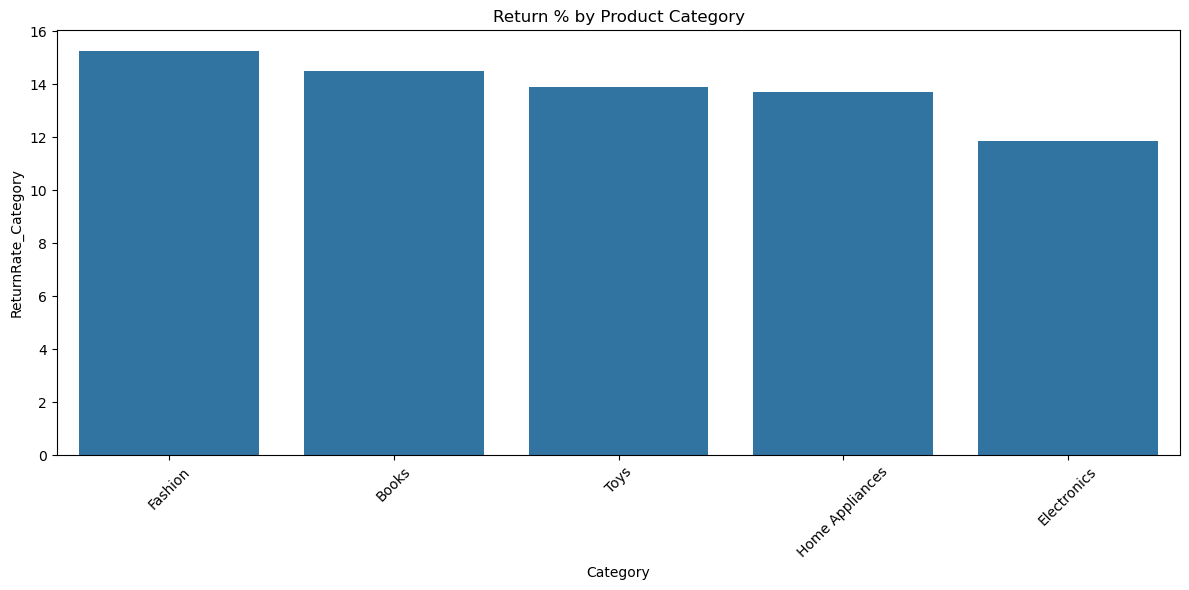

In [80]:
plt.figure(figsize=(12,6))
sns.barplot(x='Category', y='ReturnRate_Category', data=return_rate_category.sort_values(by='ReturnRate_Category', ascending=False))
plt.xticks(rotation=45)
plt.title("Return % by Product Category")
plt.tight_layout()
plt.show()

In [81]:
# Heatmap - Return rate by Geography

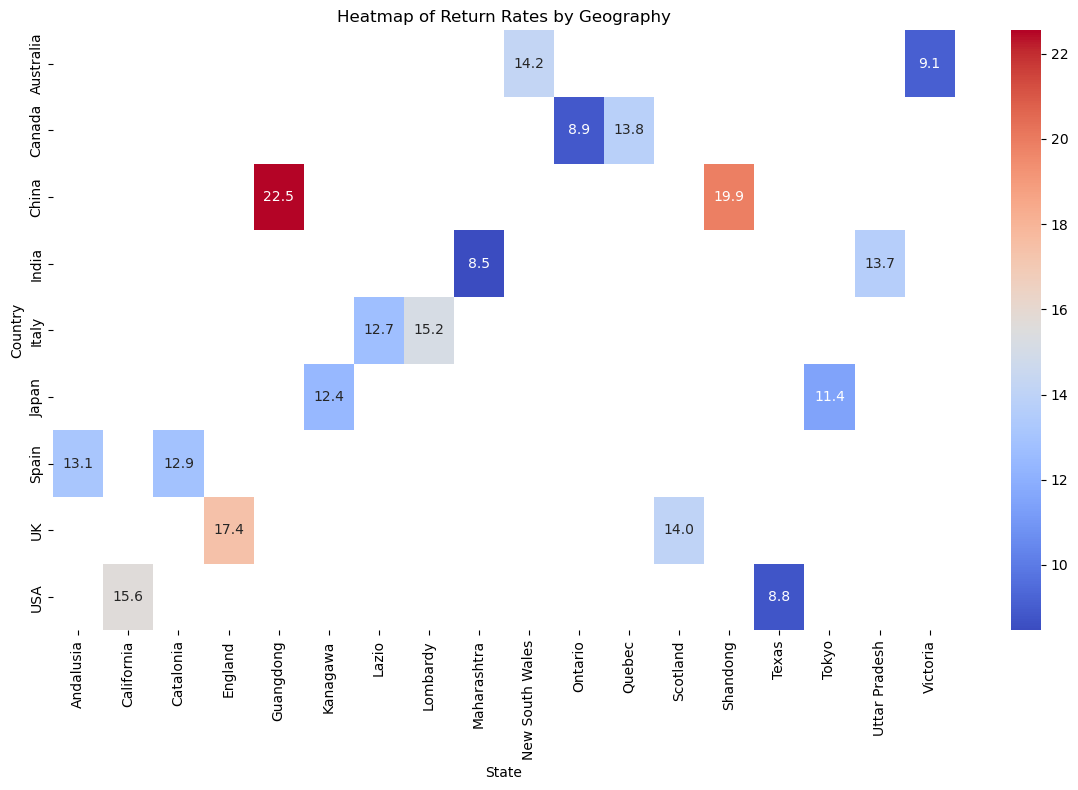

In [82]:
geo_return = return_rate_by_geography.pivot_table(index='Country', columns='State', values='ReturnRate_Percent', aggfunc='mean')
plt.figure(figsize=(12,8))
sns.heatmap(geo_return, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Heatmap of Return Rates by Geography")
plt.tight_layout()
plt.show()

In [83]:
# Return Rate by Marketing Channel

In [84]:
return_rate_channel = df.groupby('CampaignSchema').agg(
    ReturnRate_Percent=('OrderReturn', lambda x: (x == 'True').mean() * 100),
    TotalOrders=('Product', 'count')
).reset_index()

In [85]:
# Bar Chart - Return % by Marketing Channel

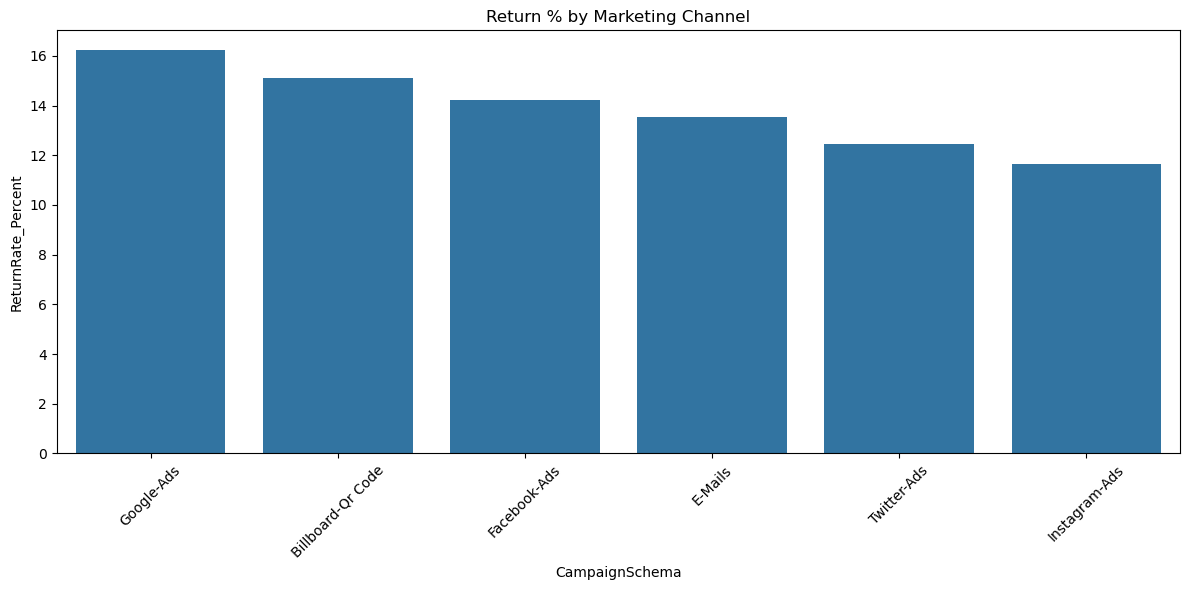

In [86]:
plt.figure(figsize=(12,6))
sns.barplot(x='CampaignSchema', y='ReturnRate_Percent', data=return_rate_channel.sort_values(by='ReturnRate_Percent', ascending=False))
plt.xticks(rotation=45)
plt.title("Return % by Marketing Channel")
plt.tight_layout()
plt.show()

In [87]:
# Bar Chart - Top Return Reasons

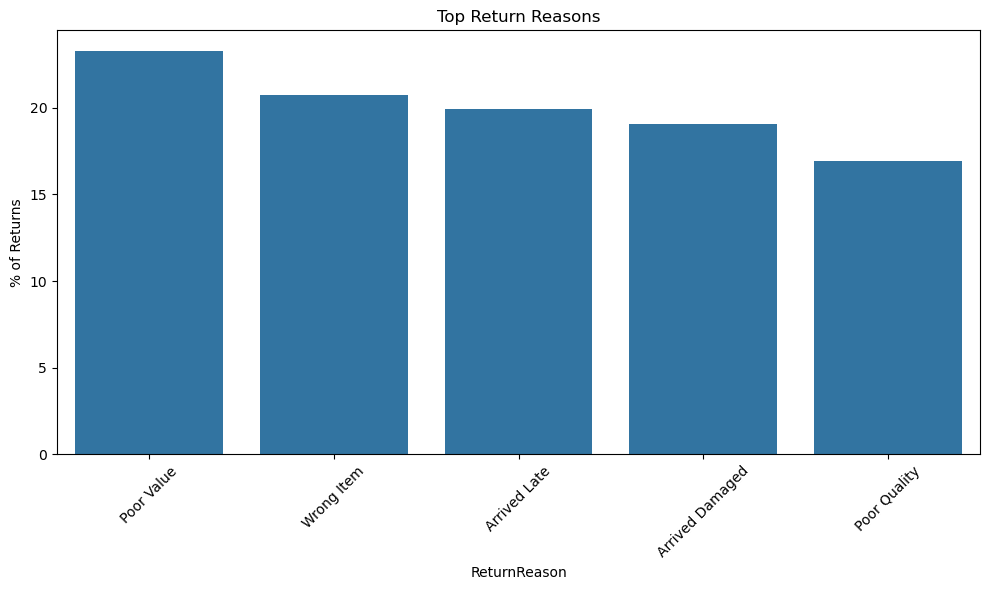

In [88]:
plt.figure(figsize=(10,6))
sns.barplot(x=return_reasons.head(10).index, y=return_reasons.head(10).values)
plt.xticks(rotation=45)
plt.ylabel("% of Returns")
plt.title("Top Return Reasons")
plt.tight_layout()
plt.show()

In [89]:
# Box Plot - Return % by Product

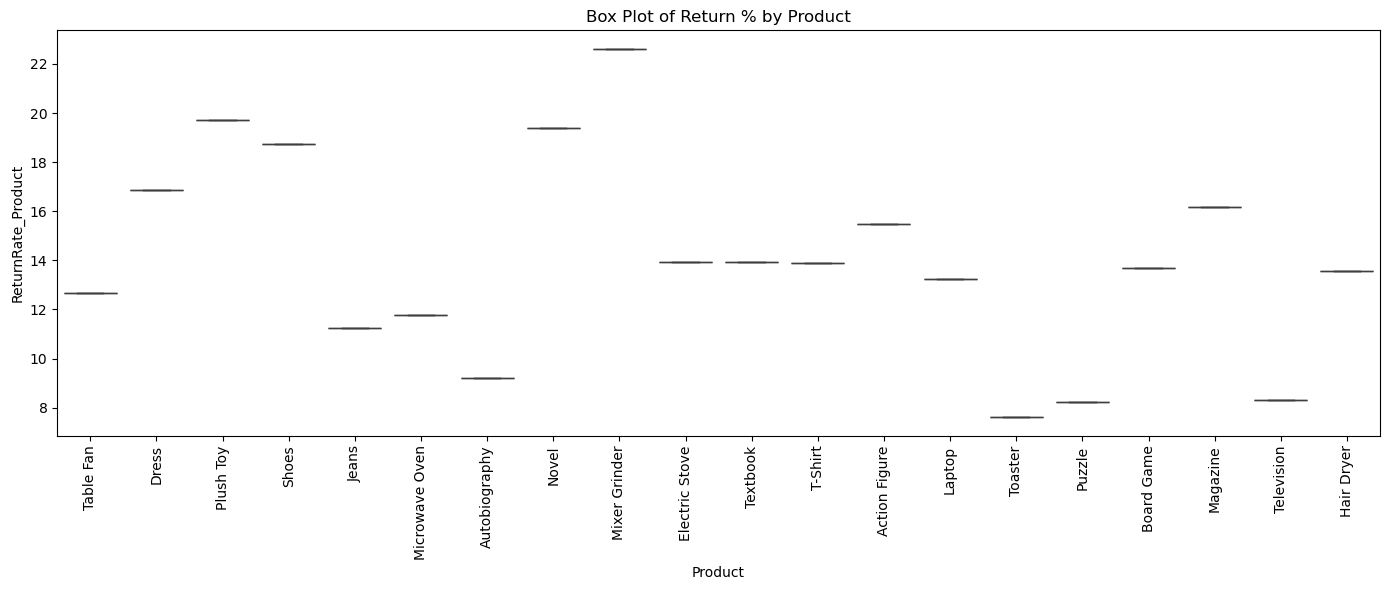

In [90]:
plt.figure(figsize=(14,6))
sns.boxplot(x='Product', y='ReturnRate_Product', data=df)
plt.xticks(rotation=90)
plt.title("Box Plot of Return % by Product")
plt.tight_layout()
plt.show()

In [91]:
print("\nEDA complete. Visual insights generated!")


EDA complete. Visual insights generated!


#### Step 10: Export cleaned dataset

In [92]:
df.to_csv("Cleaned_Customer360Insights.csv", index=False)
return_rate_by_category_and_product.to_csv("ReturnRate_By_category_and_Product.csv", index=False)
return_rate_by_category.to_csv("ReturnRate_By_Category.csv", index=False)
return_rate_by_geography.to_csv("ReturnRate_By_Geography.csv", index=False)
return_rate_by_channel.to_csv("ReturnRate_By_Channel.csv", index=False)
return_reasons.to_csv("ReturnReasons.csv", index=False)
return_rate_product.to_csv("ReturnRate_By_Product.csv", index=False)

In [95]:
print("\nData extraction from CSV, filtering, aggregation, EDA, logistic regression complete. Files generated: \n- Cleaned_Customer360Insights.csv\n- ReturnRate_By_category_and_Product.csv\n- ReturnRate_By_Category.csv\n- ReturnRate_By_Geography.csv\n- ReturnRate_By_Channel.csv\n- ReturnReasons.csv\n- ReturnRate_By_Product.csv\n- High_Risk_Products.csv\n- Predicted_Return_Probabilities.csv")


Data extraction from CSV, filtering, aggregation, EDA, logistic regression complete. Files generated: 
- Cleaned_Customer360Insights.csv
- ReturnRate_By_category_and_Product.csv
- ReturnRate_By_Category.csv
- ReturnRate_By_Geography.csv
- ReturnRate_By_Channel.csv
- ReturnReasons.csv
- ReturnRate_By_Product.csv
- High_Risk_Products.csv
- Predicted_Return_Probabilities.csv
